In [113]:
import pandas
import matplotlib.pyplot as plt
import numpy as np
import copy

# Linear kalman filter and smoother functions

This code is a very slight modification from the code in pynumdiff: https://github.com/florisvb/PyNumDiff/blob/master/pynumdiff/kalman_smooth/_kalman_smooth.py

It is based on the Kalman Filter math given in Crassidis and Junkins, Optimal Estimation of Dynamic Systems. Nothing special, but getting the syntax right is not trivial.

In [505]:
def __kalman_forward_update__(xhat_fm, P_fm, y, u, A, B, C, R, Q):
    """
    :param xhat_fm:
    :param P_fm:
    :param y:
    :param u:
    :param A:
    :param B:
    :param C:
    :param R:
    :param Q:
    :return:
    """
    
    
    I = np.array(np.eye(A.shape[0]))
    gammaW = np.array(np.eye(A.shape[0]))

    K_f = P_fm@C.T@np.linalg.pinv(C@P_fm@C.T + R)

    if y is not None:
        new_info = (y - C@xhat_fm)
        new_info[np.isnan(new_info)] = 0
        xhat_fp = xhat_fm + K_f@new_info
        
        P_fp = (I - K_f@C)@P_fm
        xhat_fm = A@xhat_fp + B@u
        P_fm = A@P_fp@A.T + gammaW@Q@gammaW.T
        
    return xhat_fp, xhat_fm, P_fp, P_fm


def __kalman_forward_filter__(xhat_fm, P_fm, y, u, A, B, C, R, Q):
    """
    :param xhat_fm:
    :param P_fm:
    :param y:
    :param u:
    :param A:
    :param B:
    :param C:
    :param R:
    :param Q:
    :return:
    """
    if u is None:
        u = np.array(np.zeros([B.shape[1], y.shape[1]]))

    xhat_fp = None
    P_fp = []
    P_fm = [P_fm]

    for i in range(y.shape[1]):
        _xhat_fp, _xhat_fm, _P_fp, _P_fm = __kalman_forward_update__(xhat_fm[:, [-1]], P_fm[-1], y[:, [i]], u[:, [i]],
                                                                     A, B, C, R, Q)
        
        if xhat_fp is None:
            xhat_fp = _xhat_fp
        else:
            xhat_fp = np.hstack((xhat_fp, _xhat_fp))
        xhat_fm = np.hstack((xhat_fm, _xhat_fm))

        P_fp.append(_P_fp)
        P_fm.append(_P_fm)

    return xhat_fp, xhat_fm, P_fp, P_fm


def __kalman_backward_smooth__(xhat_fp, xhat_fm, P_fp, P_fm, A):
    """
    :param xhat_fp:
    :param xhat_fm:
    :param P_fp:
    :param P_fm:
    :param A:
    :return:
    """
    N = xhat_fp.shape[1]

    xhat_smooth = copy.copy(xhat_fp)
    P_smooth = copy.copy(P_fp)
    for t in range(N-2, -1, -1):
        L = P_fp[t]@A.T@np.linalg.pinv(P_fm[t])
        xhat_smooth[:, [t]] = xhat_fp[:, [t]] + L@(xhat_smooth[:, [t+1]] - xhat_fm[:, [t+1]])
        P_smooth[t] = P_fp[t] - L@(P_smooth[t+1] - P_fm[t+1])

    return xhat_smooth, P_smooth

# Load data

In [521]:
dataname = 'NotWindy'

In [522]:
data_1 = pandas.read_hdf(dataname+'Predictions.h5')

In [523]:
data_2 = pandas.read_hdf(dataname+'MASigned.h5')

Text(0, 0.5, 'True Distance, m')

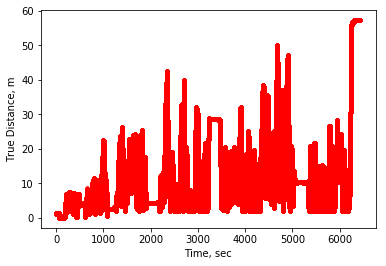

In [524]:
plt.plot(data_2.time, data_2.distance_from_source, '.', color='red')
plt.xlabel('Time, sec')
plt.ylabel('True Distance, m')

# Estimate velocity towards/away from source

Project ground velocity onto unit wind vector

In [525]:
wind_vector = np.vstack((data_2.U.values, data_2.V.values)).T
wind_magnitude = np.linalg.norm(wind_vector, axis=1)
unit_wind_vector = wind_vector / np.vstack((wind_magnitude, wind_magnitude)).T

In [526]:
velocity_vector = np.vstack((data_2.ground_speed_x.values, data_2.ground_speed_y.values)).T

In [527]:
# There is probably a more efficient syntax
velocity_ground_relative_to_wind = [np.dot(velocity_vector[i,:], unit_wind_vector[i,:]) for i in range(len(velocity_vector))]

Text(0, 0.5, 'Velocity towards/away from source, m/s')

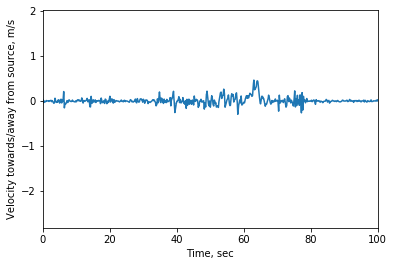

In [528]:
plt.plot(data_2.time, velocity_ground_relative_to_wind)
plt.xlim(0, 100)

plt.xlabel('Time, sec')
plt.ylabel('Velocity towards/away from source, m/s')

# Collect data into a single data frame

In [529]:
data_for_kf_original = pandas.DataFrame({'time': data_2.time, 
                                'velocity_ground_relative_to_wind': velocity_ground_relative_to_wind,
                                'distance_true': data_2.distance_from_source,
                                'distance_odor_observed': np.nan*np.ones_like(velocity_ground_relative_to_wind)})

In [530]:
# kalman filter is slow, let's subsample the data
data_for_kf = copy.copy( data_for_kf_original[::20] )

In [531]:
# put distance from odor predictions in the right places
for ix_odor in data_1.index:
    ix_kf = np.argmin( np.abs(data_1.mean_whiff_time[ix_odor] - data_for_kf.time))
    data_for_kf.distance_odor_observed[ix_kf] = data_1.predicted_distance[ix_odor]

/home/caveman/BMD2/lib/python3.5/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return bound(*args, **kwds)


Text(0, 0.5, 'Distance from source, m')

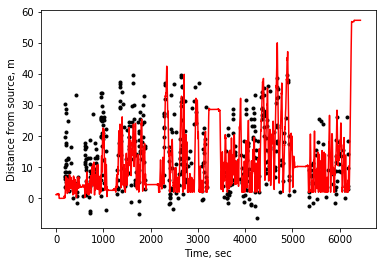

In [532]:
plt.plot(data_for_kf.time, data_for_kf.distance_odor_observed, '.', color='black')
plt.plot(data_for_kf.time, data_for_kf.distance_true, color='red')

plt.xlabel('Time, sec')
plt.ylabel('Distance from source, m')

# Define states and measurements

$
x = [distance; velocity]
$

$
y = [observed \; distance \; (from \; odor);
     ground velocity \; (towards/away \; from \; source)]
$

In [533]:
dt = np.median(np.diff(data_for_kf.time.values))
y = np.array([data_for_kf.distance_odor_observed.values, 
              data_for_kf.velocity_ground_relative_to_wind.values])

# Define dynamics: assume constant velocity

In [534]:
# constant velocity
A = np.array([[1, dt], [0, 1]])

# no explicit control inputs
B = np.array([[0], [0]])

# we have measurements of distance and velocity
C = np.array([[1, 0], [0, 1]])

# Define covariances

You can tune these. There are some methods, but doing it manually through trial and error is simplest.

In [535]:
# measurement covariances: the measurements of the observed distance are worse than the velocity measurements
R = np.array([[1e-1, 0], [0, 1e-3]])

# model covariances: the model for constant velocity is probably worse than the model for distance = integral of velocity
Q = np.array([[1e-3, 0], [0, 1e-1]])

# Define initial conditions

In [536]:
x0 = np.array([[0], [0]])
P0 = np.array(100*np.eye(2))
u = None # control input -- technically this could be the acceleration, but not needed

# Choose a subset of the measurements for testing

In [537]:
ix_start = 0
ix_end = 100000

y_subset = copy.copy( y[:, ix_start:ix_end] )
y_subset[0,0] = 5 # start with a guess for initial distance (can't be nan)

time = data_for_kf.time[ix_start:ix_end].values

# Run the filter and smoother

In [538]:
xhat_fp, xhat_fm, P_fp, P_fm = __kalman_forward_filter__(x0, P0, y_subset, u, A, B, C, R, Q)
xhat_smooth, _ = __kalman_backward_smooth__(xhat_fp, xhat_fm, P_fp, P_fm, A)

# Plot the results

Text(0, 0.5, 'Distance, m')

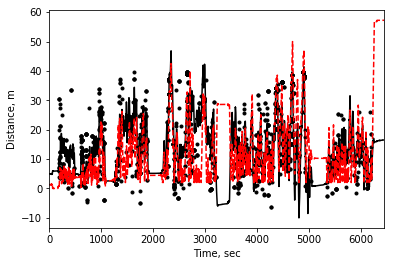

In [540]:
plt.plot(data_1.mean_whiff_time, data_1.predicted_distance, '.', color='black')
plt.plot(time, xhat_smooth[0,:], color='black')
plt.plot(data_for_kf.time, data_for_kf.distance_true, '--', color='red')

plt.xlim(0, time[-1])

plt.xlabel('Time, sec')
plt.ylabel('Distance, m')

Text(0, 0.5, 'Distance, m')

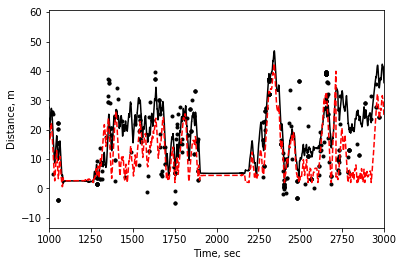

In [542]:
plt.plot(data_1.mean_whiff_time, data_1.predicted_distance, '.', color='black')
plt.plot(time, xhat_smooth[0,:], color='black')
plt.plot(data_for_kf.time, data_for_kf.distance_true, '--', color='red')

plt.xlim(1000, 3000)

plt.xlabel('Time, sec')
plt.ylabel('Distance, m')

# Minimal analysis of error

In [546]:
error = xhat_smooth[0,:] - data_for_kf.distance_true.values

median error:  5.639845105371355  meters


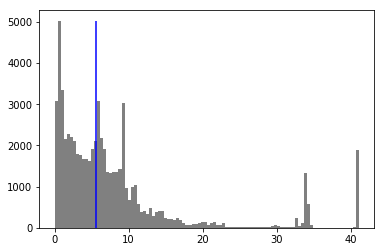

In [557]:
h = plt.hist( np.abs(error), bins=100, color='gray')

median_error = np.median(np.abs(error))
print('median error: ', median_error, ' meters')

plt.vlines(median_error, 0, np.max(h[0]), color='blue')